# 전체 프로세스 정리

## 1. 데이터 수집

- 날씨 데이터 (기상청)
 - 2016년 12월 ~ 추가 데이터 수집
 - Temperature, PrecipitationForm, PrecipitationProb, Humidity, WindSpeed, WindDirection, Cloud, Precipitation

- energy 데이터 (공공데이터포털)
 - 2016년 12월 ~ 추가 데이터 수집
 - dangjin_floating 제외 (2018년 이전 데이터 존재X)

- 태양의 고도 및 방위각 데이터 (한국천문연구원)
 - 2016년 12월 ~ 추가 데이터 수집
 - 방위각, 고도, 적경, 적위

## 2. 데이터 전처리

- 가장 최신의 예보를 바탕으로 선형보간
- 각 발전소별로 energy 결측치가 존재하는 날짜 제거

## 3. 피쳐 엔지니어링

- 각도와 시간을 나타내는 칼럼은 모두 sin, cos 값을 추가로 구함
- Temperature의 경우 계절과 시간을 기준으로 평균 Temperature를 추가로 구함

## 4. Model

- Causal Padding을 사용한 CNN1D 모델 구축
- feature selection과 추가 적인 feature engineering을 모두 모델에 맡기기 위해서 모든 feature를 사용함
- 시간에 대한 상관성을 합성곱으로 나타내고자 CNN1D 모델 구축
- 처음 부터 모델을 만드는 것은 컴퓨팅 파워와 시간 면에서 좋지 않다고 판단하여 다른 시계열 데이터에 좋은 성능을 보였던 모델을 기본 베이스로 조금 수정해서 사용
- 예측하고자 하는 시간을 기준으로 이전 3일치 데이터를 가지고 예측을 하는 방식으로 모델을 구성

## 5. 학습

- Train Data를 Random Sampling 하고 CV를 5로 학습
- 8 : 2로 Train과 Val Data를 나눠서 학습
- Loss의 경우 Metric과 유사한 MAE로 선택
- Optimization의 경우 RMSprop으로 선택(시계열의 경우 RMSprop이 조금 더 우수한 성능을 보임)
- Best Model의 경우 Val 기준으로 가장 Metric이 우수한 모델로 선택

## 6. 예측

- CV별 예측 값을 평균 내어 최종 예측값으로 활용
- CV별 예측 시에 학습이 제대로 안된 모델은 예측에서 제외
- Random Sampling의 효과로 CV별 모델이 서로 잘 맞추는 부분이 달라짐으로써 강건한 모델이 만들어짐


# OS 버전

Google Colaboratory GPU 사용

OS                   :	 Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic

Process information  :	 x86_64

Process Architecture :	 x86_64

RAM Size             :	 13(GB)

In [ ]:
import platform, psutil
 
def printOsInfo():
    print('OS                   :\t', platform.platform())

def printSystemInfor():
    print('Process information  :\t', platform.processor())
    print('Process Architecture :\t', platform.machine())
    print('RAM Size             :\t',str(round(psutil.virtual_memory().total / (1024.0 **3)))+"(GB)")

printOsInfo()
printSystemInfor()

OS                   :	 Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Process information  :	 x86_64
Process Architecture :	 x86_64
RAM Size             :	 13(GB)


# 기상청 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from glob import glob
from datetime import datetime, timedelta

import math
import time
import random

plt.style.use("fivethirtyeight")
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings(action='ignore')

ulsan_data_path = './data/울산/'
dangjin_data_path = './data/울산/'
sun_height_data_path = './data/태양광/'
energy_data_path = './data/에너지/'
result_data_path = './data/결과/'

In [ ]:
def preprocessing_3h(path_list, y):
    #데이터 불러오기
    #'forecast', 'Temperature','Precipitation','Snow','PrecipitationForm','PrecipitationProb', 'Humidity','MaxTemp','MinTemp', 'WindSpeed', 'WindDirection', 'Cloud'
    data_year_temperature = pd.read_csv(path_list[0])
    data_year_precipitation = pd.read_csv(path_list[1])
    data_year_snow = pd.read_csv(path_list[2])
    data_year_precipitationform = pd.read_csv(path_list[3])
    data_year_precipitationprob = pd.read_csv(path_list[4])
    data_year_humidity = pd.read_csv(path_list[5])
    data_year_maxtemp = pd.read_csv(path_list[6])
    data_year_mintemp = pd.read_csv(path_list[7]) 
    data_year_waveheight = pd.read_csv(path_list[8])
    data_year_windspeed = pd.read_csv(path_list[9])
    data_year_winddirection = pd.read_csv(path_list[10])
    data_year_cloud = pd.read_csv(path_list[11])

    # 데이터 결합 (3시간)
    data_year = data_year_temperature[[' format: day', 'hour', 'forecast']]
    data_year['Temperature'] = data_year_temperature[data_year_temperature.columns[-1]] #3시간 기온 
    data_year['PrecipitationForm'] = data_year_precipitationform[data_year_precipitationform.columns[-1]] #강수형태
    data_year['PrecipitationProb'] = data_year_precipitationprob[data_year_precipitationprob.columns[-1]] #강수확률
    data_year['Humidity'] = data_year_humidity[data_year_humidity.columns[-1]]#3시간 습도
    data_year['WindSpeed'] = data_year_windspeed[data_year_windspeed.columns[-1]]#3시간 풍속  
    data_year['WindDirection'] = data_year_winddirection[data_year_winddirection.columns[-1]]#3시간 풍향
    data_year['Cloud'] = data_year_cloud[data_year_cloud.columns[-1]]

    # 월 구분 행 추출
    month_rows = [-1]
    month_rows.extend(data_year[data_year['hour'].isna()].index)
    month_rows.append(data_year.shape[0]+1)
    
    # 월별 데이터 분리
    month_data = []
    for i in range(len(month_rows)-1):
        month_data.append(data_year.loc[month_rows[i]+1:month_rows[i+1]-1])
    
    # 예보 시간 생성 및 데이터 결합
    data_fcst_concat = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])
    for i, df in enumerate(month_data):
        month = i+12
        year = y
        if month >= 13:
            month = month % 12
            year += 1
        df['hour'].apply(lambda x : x[1:] if type(x) == str and x.startswith('0') else x)
        date = f'{year}-{month}-' + df[' format: day'].str.split(' ').str[-1] + ' ' + (df['hour'].astype(int)//100).astype(str) + ':00'
        
        # 시간단위 UTC => GMT
        date = pd.to_datetime(date) + pd.DateOffset(hours=9)



        data_fcst = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])
        data_fcst['Forecast time'] = date
        data_fcst[['forecast', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']] = df[['forecast', 'Temperature','PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

        data_fcst_concat = pd.concat([data_fcst_concat, data_fcst])
        
    return data_fcst_concat     

In [ ]:
def preprocessing_6h(path_list, y):
    #데이터 불러오기
    #'forecast', 'Temperature','Precipitation','Snow','PrecipitationForm','PrecipitationProb', 'Humidity','MaxTemp','MinTemp', 'WindSpeed', 'WindDirection', 'Cloud' 
    data_year_precipitation = pd.read_csv(path_list[1])
    data_year_snow = pd.read_csv(path_list[2]) 

    # 데이터 결합 (6시간)
    data_year = data_year_precipitation[[' format: day', 'hour', 'forecast']]
    data_year['Precipitation'] = data_year_precipitation[data_year_precipitation.columns[-1]] #강수량
    data_year['Snow'] = data_year_snow[data_year_snow.columns[-1]] #적설량

    # 월 구분 행 추출
    month_rows = [-1]
    month_rows.extend(data_year[data_year['hour'].isna()].index)
    month_rows.append(data_year.shape[0]+1)
    
    # 월별 데이터 분리
    month_data = []
    for i in range(len(month_rows)-1):
        month_data.append(data_year.loc[month_rows[i]+1:month_rows[i+1]-1])
     
    # 예보 시간 생성 및 데이터 결합
    data_fcst_concat = pd.DataFrame(columns=['Forecast time', 'forecast', 'Precipitation','Snow'])
    for i, df in enumerate(month_data):
        month = i+12
        year = y
        if month >= 13:
            month = month % 12
            year += 1

        date = f'{year}-{month}-' + df[' format: day'].str.split(' ').str[-1] + ' ' + (df['hour'].astype(int)//100).astype(str) + ':00'
        
        # 시간단위 UTC => GMT
        date = pd.to_datetime(date) + pd.DateOffset(hours=9)



        data_fcst = pd.DataFrame(columns=['Forecast time', 'forecast', 'Precipitation','Snow'])
        data_fcst['Forecast time'] = date
        data_fcst[['forecast','Precipitation','Snow']] = df[['forecast', 'Precipitation','Snow']]

        data_fcst_concat = pd.concat([data_fcst_concat, data_fcst])
        
    return data_fcst_concat         

In [ ]:
def to_date(x):
    return pd.DateOffset(hours=x)

def forecasting_interpolation(fcst_data, hour):
    #예보 시간 컬럼의 데이터 타입을 datetime으로 변경
    fcst_data['Forecast_time'] = pd.to_datetime(fcst_data['Forecast time'] )  

    #기상청에서는 하루 3시간 간격으로 8회 예보한다. 여기서는 23시 예보만을 사용한다.
    fcst_23 = fcst_data[fcst_data['Forecast_time'].dt.hour == 23]  

    #다음 날의 기상 예보가 필요하여 예보시간 기준 1시간 후(00:00) 부터 24시간 후 (23:00) 데이터만 사용
    fcst_23 = fcst_23[(fcst_23['forecast']>1) & (fcst_23['forecast']<=24)]

    #예보 시점에 forecast를 더하여 예보 시각을 구합니다
    fcst_23['Forecast_time'] = fcst_23['Forecast_time'] + fcst_23['forecast'].map(to_date)   

    if hour == 3:
        fcst_23 = fcst_23[['Forecast_time','Temperature','PrecipitationForm','PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    elif hour == 6:
        fcst_23 = fcst_23[['Forecast_time', 'Precipitation','Snow']]

    #interpolation
    fcst_23_ = pd.DataFrame()
    fcst_23_['Forecast_time'] = pd.date_range(start ='2016-12-02 00:00:00', end='2021-05-01 23:00:00', freq='H')

    fcst_23_ = pd.merge(fcst_23_, fcst_23, on='Forecast_time', how='outer')

    #inter_fcst_23 = fcst_23_.interpolate(method = 'polynomial', order = 3)
    #inter_fcst_23 = fcst_23_.interpolate(method = 'linear')
    return fcst_23_

In [ ]:
def to_date(x):
    return timedelta(hours=x)

def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in str(x))]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in str(x))]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    return c

In [ ]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    new_df['Forecast_time'] = new_df['Forecast_time'].astype(str)
    return new_df

In [ ]:
dangjin_csv_list = sorted(glob(dangjin_data_path + "*.csv"))
ulsan_csv_list = sorted(glob(ulsan_data_path + "*.csv"))

In [ ]:
dangjin_sun_height = pd.read_csv(sun_height_data_path + "dangjin_sun_height.csv")
ulsan_sun_height = pd.read_csv(sun_height_data_path + "ulsan_sun_height.csv")

In [ ]:
year_list = ['201612_201711',
             '201712_201811',
             '201812_201911',
             '201912_202011',
             '202012_202104']

In [ ]:
dangjin_fcst_3h = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])
for year in year_list:
  y = year[:4]
  tmp = []
  for dir in dangjin_csv_list:
    if year in dir:
      tmp.append(dir)
  data = datadata = preprocessing_3h(tmp, int(y))
  dangjin_fcst_3h = pd.concat([dangjin_fcst_3h, data])

In [ ]:
ulsan_fcst_3h = pd.DataFrame(columns=['Forecast time', 'forecast', 'Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'])
for year in year_list:
  y = year[:4]
  tmp = []
  for dir in ulsan_csv_list:
    if year in dir:
      tmp.append(dir)
  data = datadata = preprocessing_3h(tmp, int(y))
  ulsan_fcst_3h = pd.concat([ulsan_fcst_3h, data])

In [ ]:
dangjin_fcst_6h = pd.DataFrame(columns=['Forecast time', 'forecast',  'Precipitation','Snow'])
for year in year_list:
  y = year[:4]
  tmp = []
  for dir in dangjin_csv_list:
    if year in dir:
      tmp.append(dir)
  data = datadata = preprocessing_6h(tmp, int(y))
  dangjin_fcst_6h = pd.concat([dangjin_fcst_6h, data])

In [ ]:
ulsan_fcst_6h = pd.DataFrame(columns=['Forecast time', 'forecast',  'Precipitation','Snow'])
for year in year_list:
  y = year[:4]
  tmp = []
  for dir in dangjin_csv_list:
    if year in dir:
      tmp.append(dir)
  data = datadata = preprocessing_6h(tmp, int(y))
  ulsan_fcst_6h = pd.concat([ulsan_fcst_6h, data])

In [ ]:
dangjin_fcst_3h

,Forecast time,forecast,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud
0,2016-12-01 11:00:00,4.0,14.6,0.0,0.0,37.0,5.6,298.0,1.0
1,2016-12-01 11:00:00,7.0,8.1,0.0,0.0,36.0,6.5,312.0,1.0
2,2016-12-01 11:00:00,10.0,6.9,0.0,0.0,47.0,3.4,308.0,1.0
3,2016-12-01 11:00:00,13.0,5.0,0.0,0.0,49.0,2.1,307.0,1.0
4,2016-12-01 11:00:00,16.0,2.9,0.0,0.0,53.0,1.7,291.0,1.0
...,...,...,...,...,...,...,...,...,...
22347,2021-05-01 08:00:00,52.0,21.0,0.0,0.0,35.0,2.5,226.0,1.0
22348,2021-05-01 08:00:00,55.0,22.0,0.0,0.0,30.0,2.3,230.0,1.0
22349,2021-05-01 08:00:00,58.0,20.0,0.0,0.0,40.0,3.5,216.0,1.0
22350,2021-05-01 08:00:00,61.0,16.0,0.0,0.0,55.0,3.2,228.0,1.0


In [ ]:
dangjin_fcst_3h = generate_df(dangjin_fcst_3h)
ulsan_fcst_3h = generate_df(ulsan_fcst_3h)
dangjin_fcst_3h = interpolate_df(dangjin_fcst_3h, method='linear')
ulsan_fcst_3h = interpolate_df(ulsan_fcst_3h, method='linear')
dangjin_fcst_6h = forecasting_interpolation(dangjin_fcst_6h, 6)
ulsan_fcst_6h = forecasting_interpolation(ulsan_fcst_6h, 6)

In [ ]:
dangjin_fcst_3h['Forecast_time'] = pd.to_datetime(dangjin_fcst_3h['Forecast_time'])
ulsan_fcst_3h['Forecast_time'] = pd.to_datetime(ulsan_fcst_3h['Forecast_time'])

In [ ]:
dangjin_fcst = pd.merge(dangjin_fcst_3h, dangjin_fcst_6h, on = "Forecast_time", how = "outer")
ulsan_fcst = pd.merge(ulsan_fcst_3h, ulsan_fcst_6h, on = "Forecast_time", how = "outer")

In [ ]:
dangjin_fcst.columns

Index(['Forecast_time', 'Temperature', 'PrecipitationForm',
       'PrecipitationProb', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud',
       'Precipitation', 'Snow'],
      dtype='object')

In [ ]:
dangjin_fcst = dangjin_fcst.iloc[:-1487]
ulsan_fcst = ulsan_fcst.iloc[:-1487]

In [ ]:
dangjin_sun_height['month-day-hour'] = pd.to_datetime(dangjin_sun_height['date']).dt.month.astype(str) + "-" + pd.to_datetime(dangjin_sun_height['date']).dt.day.astype(str) + "-" + pd.to_datetime(dangjin_sun_height['date']).dt.hour.astype(str)
ulsan_sun_height['month-day-hour'] = pd.to_datetime(ulsan_sun_height['date']).dt.month.astype(str) + "-" + pd.to_datetime(ulsan_sun_height['date']).dt.day.astype(str) + "-" + pd.to_datetime(ulsan_sun_height['date']).dt.hour.astype(str)

In [ ]:
dangjin_fcst['month-day-hour'] = dangjin_fcst['Forecast_time'].dt.month.astype(str) + "-" + dangjin_fcst['Forecast_time'].dt.day.astype(str) + "-" + dangjin_fcst['Forecast_time'].dt.hour.astype(str)
ulsan_fcst['month-day-hour'] = ulsan_fcst['Forecast_time'].dt.month.astype(str) + "-" + ulsan_fcst['Forecast_time'].dt.day.astype(str) + "-" + ulsan_fcst['Forecast_time'].dt.hour.astype(str)

In [ ]:
dangjin_fcst = pd.merge(dangjin_fcst, dangjin_sun_height, on = 'month-day-hour')
ulsan_fcst = pd.merge(ulsan_fcst, ulsan_sun_height, on = 'month-day-hour')

In [ ]:
dangjin_fcst.drop(['month-day-hour', 'date'], axis = 1, inplace = True)
ulsan_fcst.drop(['month-day-hour', 'date'], axis = 1, inplace = True)

In [ ]:
dangjin_fcst.sort_values("Forecast_time", inplace = True)
ulsan_fcst.sort_values("Forecast_time", inplace = True)

In [ ]:
dangjin_fcst.to_csv(result_data_path + "new_dangjin_fcst.csv", index = False)
ulsan_fcst.to_csv(result_data_path + "new_ulsan_fcst.csv", index = False)

In [ ]:
dangjin_fcst

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위
0,2016-12-02 00:00:00,5.0,0.0,0.0,50.0,2.1,307.0,1.0,NaN,NaN,340 03 04.02,-74 04 10.40,16 32 56.04,-21 55 49.38
5,2016-12-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,030 19 39.37,-72 55 00.56,16 33 06.98,-21 56 11.79
10,2016-12-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060 54 26.99,-64 12 35.47,16 33 17.92,-21 56 34.29
15,2016-12-02 03:00:00,2.3,0.0,0.0,56.0,1.5,305.0,1.0,NaN,NaN,077 02 49.13,-53 01 39.40,16 33 28.84,-21 56 56.88
20,2016-12-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,087 49 23.81,-41 10 38.68,16 33 39.74,-21 57 19.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10664,2021-02-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274 36 31.31,-19 28 58.57,22 43 34.22,-8 04 37.23
10669,2021-02-28 21:00:00,14.0,0.0,30.0,75.0,4.3,154.0,4.0,NaN,NaN,284 38 48.32,-31 16 00.31,22 43 43.68,-8 03 40.40
10674,2021-02-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296 55 39.10,-42 26 50.80,22 43 53.17,-8 02 43.58
10679,2021-02-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313 32 08.08,-52 14 15.85,22 44 02.67,-8 01 46.80


In [ ]:
ulsan_fcst

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위
0,2016-12-02 00:00:00,5.0,0.0,0.0,50.0,2.1,307.0,1.0,NaN,NaN,258 00 32.56,-76 26 21.28,16 32 55.95,-21 55 48.10
5,2016-12-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164 16 44.82,-87 40 11.14,16 33 06.91,-21 56 10.46
10,2016-12-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101 28 10.66,-75 10 59.58,16 33 17.87,-21 56 32.85
15,2016-12-02 03:00:00,2.3,0.0,0.0,56.0,1.5,305.0,1.0,NaN,NaN,099 57 24.96,-61 17 24.54,16 33 28.82,-21 56 55.28
20,2016-12-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101 23 03.04,-47 24 41.33,16 33 39.76,-21 57 17.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10664,2021-02-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265 35 16.12,-11 55 23.58,22 43 34.12,-8 04 35.07
10669,2021-02-28 21:00:00,14.0,0.0,30.0,75.0,4.3,154.0,4.0,NaN,NaN,270 31 09.86,-26 01 47.12,22 43 43.57,-8 03 38.31
10674,2021-02-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276 09 24.85,-40 07 14.15,22 43 53.05,-8 02 41.55
10679,2021-02-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283 55 10.48,-54 01 26.54,22 44 02.56,-8 01 44.80


# 에너지 데이터 전처리

In [ ]:
past_energy1 = pd.read_csv(energy_data_path + "한국동서발전 시간대별 태양광 및 풍력 발전량 현황(2018_2019).csv")
past_energy2 = pd.read_csv(energy_data_path + "한국동서발전 시간대별 태양광 발전량 현황(2015_2017).csv")

In [ ]:
past_energy1['시간']=pd.to_datetime(past_energy1['시간'])
past_energy2['시간']=pd.to_datetime(past_energy2['시간'])
past_energy=pd.concat([past_energy1,past_energy2])
past_energy.sort_values(by=['시간'],ascending=True, inplace=True)

dangjin_energy=past_energy[past_energy['태양광명']=='당진태양광']
dangjin_float_energy=past_energy[past_energy['태양광명']=='당진수상태양광']
dangjin_warehouse_energy=past_energy[past_energy['태양광명']=='당진자재창고태양광']
ulsan_energy=past_energy[past_energy['태양광명']=='울산태양광']

In [ ]:
ulsan_energy=ulsan_energy[ulsan_energy['시간'].dt.year <= 2018]
ulsan_energy=ulsan_energy[~(((ulsan_energy['시간'].dt.year == 2018) >= 3))]
dangjin_energy=dangjin_energy[dangjin_energy['시간'].dt.year <= 2018]
dangjin_energy=dangjin_energy[~(((dangjin_energy['시간'].dt.year == 2018) >= 3))]
dangjin_float_energy=dangjin_float_energy[dangjin_float_energy['시간'].dt.year <= 2018]
dangjin_float_energy=dangjin_float_energy[~(((dangjin_float_energy['시간'].dt.year == 2018) >= 3))]
dangjin_warehouse_energy=dangjin_warehouse_energy[dangjin_warehouse_energy['시간'].dt.year <= 2018]
dangjin_warehouse_energy=dangjin_warehouse_energy[~(((dangjin_warehouse_energy['시간'].dt.year == 2018) >= 3))]

In [ ]:
ulsan_energy=ulsan_energy.reset_index(drop=True)
dangjin_energy=dangjin_energy.reset_index(drop=True)
dangjin_float_energy=dangjin_float_energy.reset_index(drop=True)
dangjin_warehouse_energy=dangjin_warehouse_energy.reset_index(drop=True)

dangjin=pd.DataFrame(columns=['시간','dangjin'])
dangjin_floating=pd.DataFrame(columns=['시간','dangjin_floating'])
dangjin_warehouse=pd.DataFrame(columns=['시간','dangjin_warehouse'])
ulsan=pd.DataFrame(columns=['시간','ulsan'])

dangjin['dangjin']=dangjin['dangjin'].astype(float)
dangjin_floating['dangjin_floating']=dangjin_floating['dangjin_floating'].astype(float)
dangjin_warehouse['dangjin_warehouse']=dangjin_warehouse['dangjin_warehouse'].astype(float)
ulsan['ulsan']=ulsan['ulsan'].astype(float)

for i in range(24):
    dangjin=dangjin.append(dangjin_energy,ignore_index = True)
    dangjin_floating=dangjin_floating.append(dangjin_float_energy,ignore_index = True)
    dangjin_warehouse=dangjin_warehouse.append(dangjin_warehouse_energy,ignore_index = True)
    ulsan=ulsan.append(ulsan_energy,ignore_index = True)

dangjin.sort_values(by=['시간'],ascending=True, inplace=True)
dangjin_floating.sort_values(by=['시간'],ascending=True, inplace=True)
dangjin_warehouse.sort_values(by=['시간'],ascending=True, inplace=True)
ulsan.sort_values(by=['시간'],ascending=True, inplace=True)

dangjin.reset_index(drop=True, inplace=True)
dangjin_floating.reset_index(drop=True, inplace=True)
dangjin_warehouse.reset_index(drop=True, inplace=True)
ulsan.reset_index(drop=True, inplace=True)

In [ ]:
for i in range(24):
    dangjin.iloc[i::24,0]=pd.to_datetime('20' + dangjin.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    dangjin_floating.iloc[i::24,0]=pd.to_datetime('20' + dangjin_floating.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    dangjin_warehouse.iloc[i::24,0]=pd.to_datetime('20' + dangjin_warehouse.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)
    ulsan.iloc[i::24,0]=pd.to_datetime('20' + ulsan.iloc[i::24,0].dt.strftime('%y-%m-%d')+ ' ' + str(i) + ':00') + pd.DateOffset(hours=1)

    dangjin.iloc[i::24,1]=dangjin.iloc[i::24,i+3].astype(float)
    dangjin_floating.iloc[i::24,1]=dangjin_floating.iloc[i::24,i+3].astype(float)
    dangjin_warehouse.iloc[i::24,1]=dangjin_warehouse.iloc[i::24,i+3].astype(float)
    ulsan.iloc[i::24,1]=ulsan.iloc[i::24,i+3]

dangjin=dangjin.iloc[:,0:2]
dangjin_floating=dangjin_floating.iloc[:,0:2]
dangjin_warehouse=dangjin_warehouse.iloc[:,0:2]
ulsan=ulsan.iloc[:,0:2]
dangjin.columns = ['time', 'dangjin']
dangjin_floating.columns = ['time', 'dangjin_floating']
dangjin_warehouse.columns = ['time', 'dangjin_warehouse']
ulsan.columns = ['time', 'ulsan']

In [ ]:
new_energy= pd.DataFrame(columns=['time'])
new_energy['time'] = pd.date_range(start='2015-01-01 01:00:00', end='2018-03-01 00:00:00', freq='H')
new_energy = pd.merge(new_energy, dangjin_floating, on=['time'], how='outer')
new_energy = pd.merge(new_energy, dangjin_warehouse, on=['time'],how='outer')
new_energy = pd.merge(new_energy, dangjin, on=['time'], how='outer')
new_energy = pd.merge(new_energy, ulsan, on=['time'],how='outer')

In [ ]:
energy = pd.read_csv(energy_data_path + "energy.csv")

In [ ]:
energy = pd.concat([new_energy.iloc[16823:27720], energy]).reset_index(drop = "index")

In [ ]:
energy.to_csv(result_data_path + "new_energy.csv", index = False)

In [ ]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2016-12-02 00:00:00,NaN,0.0,0.0,0.0
1,2016-12-02 01:00:00,NaN,0.0,0.0,0.0
2,2016-12-02 02:00:00,NaN,0.0,0.0,0.0
3,2016-12-02 03:00:00,NaN,0.0,0.0,0.0
4,2016-12-02 04:00:00,NaN,0.0,0.0,0.0
...,...,...,...,...,...
36524,2021-01-31 20:00:00,0.0,0.0,0.0,0.0
36525,2021-01-31 21:00:00,0.0,0.0,0.0,0.0
36526,2021-01-31 22:00:00,0.0,0.0,0.0,0.0
36527,2021-01-31 23:00:00,0.0,0.0,0.0,0.0


# 다음날 예보 데이터 추가

In [ ]:
import pandas as pd
import numpy as np
import urllib
import urllib.request
import json

PATHS = './data/결과/'

In [ ]:
'''
Temperature       : 기온      : T3H
PrecipitationForm : 강수 형태 : PTY
PrecipitationProb : 강수 확률 : POP
Humidity          : 습도      : REH
WindSpeed         : 풍속      : WSD
WindDirection     : 풍향      : VEC
Cloud             : 하늘 상태 : SKY
Precipitation     : 강수량    : R06

울산 좌표
nx : 102
ny : 83

당진 좌표
nx : 54
ny : 112
'''

In [ ]:
# # 울산 좌표
# nx = '102'
# ny = '83'

# 당진 좌표
nx = '54'
ny = '112'

ServiceKey = 'API key 값 입력'

In [ ]:
url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst'

queryParams = '?' + urllib.parse.urlencode(
    {
        urllib.parse.quote_plus('ServiceKey') : ServiceKey, # key를 바로 입력해도 됩니다.
        urllib.parse.quote_plus('numOfRows') : '113', # 총 14개의 항목을 3시간 단위로 순차적으로 불러옵니다. 다음날 24시간예보에 필요한 만큼만 가져왔습니다.
        urllib.parse.quote_plus('dataType') : 'JSON', # JSON, XML 두가지 포멧을 제공합니다.
        urllib.parse.quote_plus('base_date') : '20210708', # 예보 받을 날짜를 입력합니다. 최근 1일간의 자료만 제공합니다.
        urllib.parse.quote_plus('base_time') : '1700', # 예보 시간을 입력합니다. 2시부터 시작하여 3시간 단위로 입력 가능합니다.
        urllib.parse.quote_plus('nx') : nx, # 울산 태양광 발전소 x 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
        urllib.parse.quote_plus('ny') : ny # 울산 태양광 발전소 y 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
    }
)

response = urllib.request.urlopen(url + queryParams).read()
response = json.loads(response)

In [ ]:
fcst_df = pd.DataFrame()
date = '2021-07-09'
fcst_df['Forecast_time'] = [f'{date} {hour}:00' for hour in range(24)]
row_idx = 0

for i, data in enumerate(response['response']['body']['items']['item']):
        # print(i)
      if i >= 9 and i < 102:
        if data['category']=='REH':
            fcst_df.loc[row_idx, 'Humidity'] = float(data['fcstValue'])
            print('category:Humidity,', data['category'], ', baseDate:', data['baseDate'], ', baseTime:', data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        
        elif data['category']=='T3H':
            fcst_df.loc[row_idx, 'Temperature'] = float(data['fcstValue'])
            print('category:Temperature,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        
        elif data['category']=='SKY':
            fcst_df.loc[row_idx, 'Cloud'] = float(data['fcstValue'])
            print('category:Cloud,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])
        
        elif data['category']=='VEC':
            fcst_df.loc[row_idx, 'WindDirection'] = float(data['fcstValue'])
            print('category:WindDirection,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])

        elif data['category']=='PTY':
            fcst_df.loc[row_idx, 'PrecipitationForm'] = float(data['fcstValue'])
            print('category:PrecipitationForm,',data['category'],  ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])        

        elif data['category']=='POP':
            fcst_df.loc[row_idx, 'PrecipitationProb'] = float(data['fcstValue'])
            print('category:PrecipitationProb,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])

        elif data['category']=='R06':
            fcst_df.loc[row_idx, 'Precipitation'] = float(data['fcstValue'])
            print('category:Precipitation,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'])

        elif data['category']=='WSD':
            fcst_df.loc[row_idx, 'WindSpeed'] = float(data['fcstValue'])
            print('category:WindSpeed,',data['category'], ', baseDate:', data['baseDate'] , ', baseTime:',data['baseTime'],', fcstDate', data['fcstDate'], ', fcstTime:', data['fcstTime'], ', fcstValue:', data['fcstValue'], '\n')
            row_idx+=3

category:PrecipitationProb, POP , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 0
category:PrecipitationForm, PTY , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 0
category:Precipitation, R06 , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 0
category:Humidity, REH , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 90
category:Cloud, SKY , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 1
category:Temperature, T3H , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 25
category:WindDirection, VEC , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 160
category:WindSpeed, WSD , baseDate: 20210713 , baseTime: 1700 , fcstDate 20210714 , fcstTime: 0000 , fcstValue: 2 

category:PrecipitationProb, POP , baseDate: 20210713 , baseTi

In [ ]:
fcst_df['Forecast_time'] = pd.date_range(start = '2021-07-09 00:00:00', end = '2021-07-10 00:00:00', freq='H')
fcst_df

,Forecast_time,PrecipitationProb,PrecipitationForm,Precipitation,Humidity,Cloud,Temperature,WindDirection,WindSpeed
0,2021-07-09 00:00:00,0.0,0.0,0.0,90.0,1.0,25.0,160.0,2.0
1,2021-07-09 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-07-09 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-07-09 03:00:00,0.0,0.0,NaN,95.0,1.0,25.0,151.0,2.3
4,2021-07-09 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-07-09 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-07-09 06:00:00,10.0,0.0,0.0,95.0,1.0,24.0,143.0,2.6
7,2021-07-09 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-07-09 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-07-09 09:00:00,20.0,0.0,NaN,85.0,3.0,27.0,180.0,4.6


## 데이터 사전 전처리

In [ ]:
fcst_df.to_csv(PATHS + '당진데이터_20210709.csv')

In [ ]:
fcst_df.to_csv(PATHS + '울산데이터_20210709.csv')

In [ ]:
dangjin_fcst = pd.read_csv(PATHS + '당진데이터_20210709.csv').drop('Unnamed: 0',axis=1)
ulsan_fcst = pd.read_csv(PATHS + '울산데이터_20210709.csv').drop('Unnamed: 0',axis=1)

In [ ]:
dangjin_sun = pd.read_csv(PATHS + 'dangjin_sun_height.csv').drop('Unnamed: 0',axis=1)
ulsan_sun = pd.read_csv(PATHS + 'ulsan_sun_height.csv').drop('Unnamed: 0',axis=1)

In [ ]:
def interpolate_df(df_, method='linear'):
  
    df = df_.copy()
    df['Forecast_time'] = pd.to_datetime(df['Forecast_time'])

    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    
    return new_df.interpolate(method=method)

In [ ]:
# 선형보간하는 부분
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast_time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast_time'])
dangjin_interpolated = interpolate_df(dangjin_fcst, method='linear')
ulsan_interpolated = interpolate_df(ulsan_fcst, method='linear')

In [ ]:
# 날짜데이터 쪼개고 결측치 0으로 채우기
dangjin_interpolated['hour'] = dangjin_interpolated['Forecast_time'].dt.hour
dangjin_interpolated['date'] = dangjin_interpolated['Forecast_time'].dt.date
dangjin_interpolated['month'] = dangjin_interpolated['Forecast_time'].dt.month
dangjin_interpolated['day'] = dangjin_interpolated['Forecast_time'].dt.day
dangjin_interpolated = dangjin_interpolated.fillna(0)

ulsan_interpolated['hour'] = ulsan_interpolated['Forecast_time'].dt.hour
ulsan_interpolated['date'] = ulsan_interpolated['Forecast_time'].dt.date
ulsan_interpolated['month'] = ulsan_interpolated['Forecast_time'].dt.month
ulsan_interpolated['day'] = ulsan_interpolated['Forecast_time'].dt.day
ulsan_interpolated = ulsan_interpolated.fillna(0)

In [ ]:
# Concat할 예보날짜의 고도 인덱스
d_idx =  dangjin_sun[dangjin_sun['date'] == str(dangjin_interpolated['date'][0])].index.values
d_idx = np.append(d_idx,np.array([d_idx[23]+1]))
u_idx =  ulsan_sun[ulsan_sun['date'] == str(ulsan_interpolated['date'][0])].index.values
u_idx = np.append(u_idx,np.array([u_idx[23]+1]))

In [ ]:
# 고도와 예보 Concat
dangjin_interpolated = pd.concat([dangjin_interpolated.drop(['hour','date'],axis=1),dangjin_sun.loc[d_idx].reset_index(drop=True)],axis=1)
ulsan_interpolated = pd.concat([ulsan_interpolated.drop(['hour','date'],axis=1),ulsan_sun.loc[u_idx].reset_index(drop=True)],axis=1)

In [ ]:
dangjin_finish = pd.read_csv(PATHS + '당진데이터_완료_20210707.csv')
ulsan_finish = pd.read_csv(PATHS + '울산데이터_완료_20210707.csv')

In [ ]:
# 겹치는 부분인 마지막행 제거
dangjin_finish = dangjin_finish.drop(len(dangjin_finish)-1)
ulsan_finish = ulsan_finish.drop(len(ulsan_finish)-1)

In [ ]:
# 완료데이터에 concat
dangjin = pd.concat([dangjin_finish,dangjin_interpolated]).reset_index(drop=True)
ulsan = pd.concat([ulsan_finish,ulsan_interpolated]).reset_index(drop=True)

In [ ]:
dangjin.tail(26)

,Unnamed: 0,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,방위각,고도,적경,적위,hour,date,month,day
37992,NaN,2021-07-08 23:00:00,22.333333,0.0,30.000000,93.333333,1.666667,310.000000,4.000000,0.0,334 26 22.11,-26 07 36.61,07 12 06.45,22 24 04.37,23,2021-07-08,7,8
37993,NaN,2021-07-09 00:00:00,22.000000,0.0,30.000000,95.000000,0.600000,252.000000,4.000000,0.0,349 34 31.73,-29 50 33.09,07 12 16.82,22 23 46.59,0,2021-07-09,7,9
37994,NaN,2021-07-09 01:00:00,22.000000,0.0,30.000000,95.000000,0.766667,249.000000,4.000000,0.0,005 35 56.87,-30 21 12.96,07 12 27.18,22 23 28.89,1,2021-07-09,7,9
37995,NaN,2021-07-09 02:00:00,22.000000,0.0,30.000000,95.000000,0.933333,246.000000,4.000000,0.0,021 08 11.19,-27 34 47.73,07 12 37.55,22 23 11.29,2,2021-07-09,7,9
37996,NaN,2021-07-09 03:00:00,22.000000,0.0,30.000000,95.000000,1.100000,243.000000,4.000000,0.0,035 05 25.85,-21 55 43.60,07 12 47.90,22 22 53.78,3,2021-07-09,7,9
37997,NaN,2021-07-09 04:00:00,22.000000,0.0,30.000000,95.000000,0.933333,239.000000,4.000000,0.0,047 06 02.11,-14 03 14.99,07 12 58.23,22 22 36.33,4,2021-07-09,7,9
37998,NaN,2021-07-09 05:00:00,22.000000,0.0,30.000000,95.000000,0.766667,235.000000,4.000000,0.0,057 22 48.51,-4 35 27.14,07 13 08.53,22 22 18.93,5,2021-07-09,7,9
37999,NaN,2021-07-09 06:00:00,22.000000,0.0,30.000000,95.000000,0.600000,231.000000,4.000000,0.0,066 23 09.87,05 57 39.42,07 13 18.80,22 22 01.55,6,2021-07-09,7,9
38000,NaN,2021-07-09 07:00:00,23.000000,0.0,30.000000,93.333333,0.966667,232.000000,4.000000,0.0,074 38 18.00,17 14 08.36,07 13 29.04,22 21 44.15,7,2021-07-09,7,9
38001,NaN,2021-07-09 08:00:00,24.000000,0.0,30.000000,91.666667,1.333333,233.000000,4.000000,0.0,082 42 27.06,28 57 36.22,07 13 39.24,22 21 26.69,8,2021-07-09,7,9


In [ ]:
ulsan.tail(26)

,Unnamed: 0,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,방위각,고도,적경,적위,hour,date,month,day
37992,NaN,2021-07-08 23:00:00,24.000000,0.000000,30.0,90.000000,0.933333,65.666667,4.0,0.000000,320 39 53.00,-36 48 35.07,07 12 06.34,22 24 07.36,23,2021-07-08,7,8
37993,NaN,2021-07-09 00:00:00,24.000000,4.000000,60.0,90.000000,1.400000,54.000000,4.0,4.500000,336 05 18.98,-44 16 22.46,07 12 16.72,22 23 49.60,0,2021-07-09,7,9
37994,NaN,2021-07-09 01:00:00,23.666667,4.000000,60.0,90.000000,1.233333,156.000000,4.0,4.666667,355 27 39.33,-47 47 25.23,07 12 27.10,22 23 31.87,1,2021-07-09,7,9
37995,NaN,2021-07-09 02:00:00,23.333333,4.000000,60.0,90.000000,1.066667,258.000000,4.0,4.833333,015 46 36.36,-46 23 38.02,07 12 37.49,22 23 14.18,2,2021-07-09,7,9
37996,NaN,2021-07-09 03:00:00,23.000000,4.000000,60.0,90.000000,0.900000,360.000000,4.0,5.000000,033 06 59.72,-40 29 53.94,07 12 47.87,22 22 56.52,3,2021-07-09,7,9
37997,NaN,2021-07-09 04:00:00,23.000000,2.666667,50.0,90.000000,1.100000,257.666667,4.0,5.166667,046 08 19.69,-31 27 00.86,07 12 58.23,22 22 38.89,4,2021-07-09,7,9
37998,NaN,2021-07-09 05:00:00,23.000000,1.333333,40.0,90.000000,1.300000,155.333333,4.0,5.333333,055 35 05.39,-20 28 28.09,07 13 08.57,22 22 21.27,5,2021-07-09,7,9
37999,NaN,2021-07-09 06:00:00,23.000000,0.000000,30.0,90.000000,1.500000,53.000000,4.0,5.500000,062 32 38.28,-8 21 03.44,07 13 18.87,22 22 03.65,6,2021-07-09,7,9
38000,NaN,2021-07-09 07:00:00,23.333333,0.000000,30.0,90.000000,1.433333,45.000000,4.0,4.583333,067 49 49.44,04 28 18.38,07 13 29.13,22 21 46.02,7,2021-07-09,7,9
38001,NaN,2021-07-09 08:00:00,23.666667,0.000000,30.0,90.000000,1.366667,37.000000,4.0,3.666667,071 57 29.93,17 44 05.83,07 13 39.35,22 21 28.35,8,2021-07-09,7,9


In [ ]:
dangjin.to_csv(PATHS + '당진데이터_완료_20210708.csv', index=False)
ulsan.to_csv(PATHS + '울산데이터_완료_20210708.csv', index=False)

# 조금 더 세밀한 예보 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

data_paths = './data/결과/'
model_paths = './my_model/'

In [ ]:
dangjin_fcst = pd.read_csv(data_paths + '당진데이터_완료_20210707.csv')
ulsan_fcst = pd.read_csv(data_paths + '울산데이터_완료_20210707.csv')

dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast_time']) # Datetime으로 type 변경
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast_time']) # Datetime으로 type 변경

In [ ]:
 # 비어있는 결측치 선형보간으로 채우는 함수
def interpolate_df(df_, method='linear'):
  
    df = df_.copy()
    df['Forecast_time'] = pd.to_datetime(df['Forecast_time'])

    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H') #Forecast_time에 맞는 날짜 범위 생성
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    
    return new_df.interpolate(method=method)

In [ ]:
dangjin_interpolated = interpolate_df(dangjin_fcst, method='linear')
ulsan_interpolated = interpolate_df(ulsan_fcst, method='linear')

In [ ]:
# 날짜 변수 연,월,일 쪼개기
dangjin_interpolated['hour'] = dangjin_interpolated['Forecast_time'].dt.hour
dangjin_interpolated['date'] = dangjin_interpolated['Forecast_time'].dt.date
dangjin_interpolated['month'] = dangjin_interpolated['Forecast_time'].dt.month
dangjin_interpolated['day'] = dangjin_interpolated['Forecast_time'].dt.day
dangjin_interpolated = dangjin_interpolated.fillna(0)

ulsan_interpolated['hour'] = ulsan_interpolated['Forecast_time'].dt.hour
ulsan_interpolated['date'] = ulsan_interpolated['Forecast_time'].dt.date
ulsan_interpolated['month'] = ulsan_interpolated['Forecast_time'].dt.month
ulsan_interpolated['day'] = ulsan_interpolated['Forecast_time'].dt.day
ulsan_interpolated = ulsan_interpolated.fillna(0)

In [ ]:
# 에너지 데이터 전처리 (연월일 생성, 시간대 맞추기)
energy = pd.read_csv(data_paths + 'new_energy.csv')
energy['time'] = ulsan_interpolated[:len(energy)]['Forecast_time'].values
energy['time'] = pd.to_datetime(energy['time'])
energy['hour'] = energy['time'].dt.hour
energy['date'] = energy['time'].dt.date
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy = energy[:-1]

In [ ]:
energy_list = ['dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']

def get_energy_df(col):
  if 'dangjin' in col:
    _df = dangjin_interpolated.copy()
  else:
    _df = ulsan_interpolated.copy()

  _energy = energy.copy()
  # 일별 에너지의 합이 0일 경우, 발전소 점검 및 기계 고장 등의 이슈로 판단하여 제거함
  null_idx = energy[energy[col].isna()]['time'].values

  floating = energy.groupby('date')[col].sum()
  zero_floating_idx = floating[floating == 0].index

  _df = _df[~_df['Forecast_time'].isin(null_idx)]
  _energy = _energy[~_energy['time'].isin(null_idx)]

  _df = _df[~_df['date'].isin(zero_floating_idx)]
  _energy = _energy[~_energy['date'].isin(zero_floating_idx)]

  _df = _df.reset_index(drop=True)
  _energy = _energy.reset_index(drop=True)
  cols = ['time', col]

  _df = pd.concat([_df, _energy[cols]], axis=1)

  return _df

In [ ]:
dangjin_floating_df = get_energy_df('dangjin_floating')
dangjin_warehouse_df = get_energy_df('dangjin_warehouse')
dangjin_df = get_energy_df('dangjin')
ulsan_df = get_energy_df('ulsan')

# 피쳐 엔지니어링

In [ ]:
#Angle Feature 변환
#WindDirection angle 자체는 설명력이 부족하므로 아래 두 변환을 수행
#풍향에 대해 sin, cos변환 하여 각각 x축, y축 방향성을 갖는 값으로 변환 -> WindDirection_x, WindDirection_y
#고도각 및 방위각 등 태양의 고도와 관련된 각도 변수 또한 방향성을 갖는 값으로 변환 -> 방위각_x, 방위각_y
#sin, cos변환된 값에 WindSpeed를 곱하여 새로운 feature 생성 -> Wind_x, Wind_y (Wind = WindDirection * WindSpeed)
# 출처 : <코드공유> EDA & nfold cv를 위한 customized class & baseline - 동준이
def angle_to_cos(x):
    return np.cos(np.pi/180*(x-90))
    
def angle_to_sin(x):
    return np.sin(np.pi/180*(x+90))

def angle_to_dir(x):
    if pd.isnull(x):
        return np.nan
    elif x >= 22.5 and x <67.5:
        return 0
    elif x >= 67.5 and x < 112.5:
        return 1
    elif x >= 112.5 and x < 157.5:
        return 2
    elif x >= 157.5 and x < 202.5:
        return 3
    elif x >= 202.5 and x < 247.5:
        return 4
    elif x >= 247.5 and x < 292.5:
        return 5
    elif x >= 292.5 and x < 337.5:
        return 6
    elif x >= 337.5 or x < 22.5:
        return 7

def change_angle(x) :
  if x == 0: return 0
  d, m, s = x.split()
  if int(d) > 0 :
    return int(d) + int(m)/60 + float(s)/3600
  else :
    return -1 * (-int(d) + int(m)/60 + float(s)/3600)

def get_feature(df):
  _df = df.copy()

  # WindDirection_catg
  _df['WindDirection_catg'] = _df['WindDirection'].apply(lambda x: angle_to_dir(x))

  # WindDirection_x
  _df['WindDirection_x'] = _df['WindDirection'].map(lambda x : angle_to_cos(x))
  _df['WindDirection_y'] = _df['WindDirection'].map(lambda x : angle_to_sin(x))

  # cos_time
  _df['cos_time'] = np.cos(2*np.pi*(_df['hour']/24))
  _df['sin_time'] = np.sin(2*np.pi*(_df['hour']/24))

  # Wind_x
  _df['Wind_x'] = _df['WindDirection_x'] * _df['WindSpeed']
  _df['Wind_y'] = _df['WindDirection_y'] * _df['WindSpeed']

  # DP, 여러 태양광 및 태양열 에너지 관련 논문을 리서치해봤을 때, 이슬점과 태양에너지 간의 상관성이 있다고 판단되어 변수 생성
  c = 243.12
  b = 17.62
  gamma = (b * (_df['Temperature']) / (c + (_df['Temperature']))) + np.log(_df['Humidity'] / 100)
  dp = ( c * gamma) / (b - gamma)
  _df['DP'] = dp

  # 방위각, 고도, 적경, 적위 등 태양의 각도와 관련 있는 변수. 발전소의 위치와 태양이 이루는 각도에 따라 발전량이 달라질 것으로 고려하여 추가
  _df['방위각'] = _df['방위각'].apply(lambda x : change_angle(x))
  _df['방위각_x'] = _df['방위각'].apply(lambda x : angle_to_cos(x))
  _df['방위각_y'] = _df['방위각'].apply(lambda x : angle_to_sin(x))

  _df['고도'] = _df['고도'].apply(lambda x : change_angle(x))
  _df['고도_x'] = _df['고도'].apply(lambda x : angle_to_cos(x))
  _df['고도_y'] = _df['고도'].apply(lambda x : angle_to_sin(x))

  _df['적경'] = _df['적경'].apply(lambda x : change_angle(x))
  _df['적경_x'] = _df['적경'].apply(lambda x : angle_to_cos(x))
  _df['적경_y'] = _df['적경'].apply(lambda x : angle_to_sin(x))

  _df['적위'] = _df['적위'].apply(lambda x : change_angle(x))
  _df['적위_x'] = _df['적위'].apply(lambda x : angle_to_cos(x))
  _df['적위_y'] = _df['적위'].apply(lambda x : angle_to_sin(x))

  # diurnal temperature 일교차 생성
  hour_mean = _df.groupby(_df['hour']).Temperature.mean()
  hour_mean = pd.DataFrame(hour_mean)
  hour_mean.columns = ['hour_mean_temp']

  _df = _df.merge(hour_mean, on='hour', how='left')
  _df['dinual_Temperature'] = _df['Temperature'].sub(_df['hour_mean_temp'])

  # seasonal_Temperature 계절성을 반영하기 위한 월별 평균온도 생성
  month_mean = _df.groupby(_df['month']).Temperature.mean()
  month_mean = pd.DataFrame(month_mean)
  month_mean.columns = ['month_mean_temp']

  _df = _df.merge(month_mean, on='month', how='left')
  _df['seasonal_Temperature'] = _df['Temperature'].sub(_df['month_mean_temp'])

  return _df

In [ ]:
dangjin_floating_df = get_feature(dangjin_floating_df)
dangjin_warehouse_df = get_feature(dangjin_warehouse_df)
dangjin_df = get_feature(dangjin_df)
ulsan_df = get_feature(ulsan_df)

# CNN1D

In [ ]:
def build_dataset(time_series, hour_series, seq_length): #CNN 모델에 사용할 데이터셋 생성 
  dataX = []
  dataY = []
  dataHour = []

# seq_length는 시계열을 얼마나 반영할지에 대한 Hyperparameter
  for i in range(0, len(time_series) - seq_length): 
    _x = time_series[i:i + seq_length, :-1]
    _y = time_series[i + seq_length, -1]
    _hour = hour_series[i + seq_length]

    dataX.append(_x)
    dataY.append(_y)
    dataHour.append(_hour)
    
  return np.array(dataX), np.array(dataY), np.array(dataHour)

def get_train_val_test(df, target): # Train/Val/Test Set 생성
  _df = df.copy()

  _hour = df['Forecast_time'].values
  # 모델에 반영할 Columns
  # feature selection과 추가적인 feature engineering을 모두 모델에 맡기기 위해서 모든 feature를 사용함
  cols = ['Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed', 
 'WindDirection', 'Cloud', 'Precipitation', '방위각',
 '고도', '적경', '적위', 'hour', 'month', 'WindDirection_x', 'WindDirection_y', 'cos_time',
 'Wind_x', 'Wind_y', 'DP', '방위각_x', '방위각_y',
 '고도_x', '고도_y', '적경_x', '적경_y', '적위_x',
 '적위_y', 'dinual_Temperature', 'seasonal_Temperature']

  min = _df[cols].values.min(axis=0)
  max = _df[cols].values.max(axis=0)

  _df.loc[:, cols] = (_df[cols] - min) / (max - min)

  # 모델에 반영할 Columns + target
  cols = ['Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed',
 'WindDirection', 'Cloud', 'Precipitation', '방위각',
 '고도', '적경', '적위', 'hour', 'month', 
 'WindDirection_x', 'WindDirection_y', 'cos_time', 'Wind_x', 'Wind_y',
 'DP', '방위각_x', '방위각_y', '고도_x', '고도_y',
 '적경_x', '적경_y', '적위_x', '적위_y', 'dinual_Temperature',
 'seasonal_Temperature', target]

  X = _df[cols].values

  X, y, hour = build_dataset(time_series = X, hour_series = _hour, seq_length = 72) # seq_length = 72. 즉, 3일치 데이터를 가지고 예측 
  
  # 데이터 셋 사이즈 결정
  publict_test_size = 28 * 24
  skip_size = (8 * 24) + (31 * 24) + (30 * 24) + (31 * 24)
  private_test_size = 720

  X_train = X[: -(private_test_size + skip_size + publict_test_size)]
  y_train = y[: -(private_test_size + skip_size + publict_test_size)]

  # 결측치 제거
  y_train[-1] = 0
  Hour_train = hour[: -(private_test_size + skip_size + publict_test_size)]

  X_publict_test = X[-(private_test_size + skip_size + publict_test_size): -(private_test_size + skip_size)]
  Hour_publict_test = hour[-(private_test_size + skip_size + publict_test_size): -(private_test_size + skip_size)]

  X_private_test = X[-private_test_size: ]
  Hour_private_test = hour[-private_test_size: ]

  return X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,MaxPooling1D,BatchNormalization, Lambda, AveragePooling1D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras as keras

def sola_nmae(answer, pred): # 대회 제공 평가지표 함수
    absolute_error = np.abs(answer - pred) # 실제값과 정답값의 차이 절대값
    
    absolute_error /= capacity # capacity : 발전소 발전용량
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

def my_metric(answer, pred): # 메트릭 Score로 출력되도록 하는 함수, sola_nmae 사용
  score = tf.py_function(func=sola_nmae, inp=[answer, pred], Tout=tf.float32,  name='custom_nmae')
  return score

# 시간에 대한 상관성을 합성곱으로 나타내고자 CNN1D 모델 구축
def set_model(): # Causal Padding을 사용한 CNN1D 모델 구축함수

  nf = 16 
  fs = 3 
  padding = 'causal'  # Convolution을 진행할 때, 매 step에서 output이 오직 현시점의 input과 과거 시점들의 데이터에만 종속되도록하기 위해서 Causal Padding을 사용
  activation = 'elu' # Gradient Vanishing 문제를 방지하기 위해서 Elu 사용

  model = Sequential()

  model.add(keras.layers.InputLayer((72, 30)))

  model.add(Conv1D(filters = nf, kernel_size = fs, padding = padding))
  model.add(BatchNormalization()) # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 2, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())  # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 4, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())  # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 8, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())  # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 16, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())  # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 32, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())  # 비선형 성질을 유지 하면서 학습 될 수 있게 해주고, regularization 효과를 가지기 위해 배치정규화 설정
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  # Convolution 연산을 진행한 결과를 다시 Flatten 하여 최종 값(Dense(1)) 도출
  model.add(Flatten())
  model.add(Dense(512, activation = activation))
  model.add(Dense(128, activation = activation)) 
  model.add(Dense(32, activation = activation)) 
  model.add(Dense(8, activation = activation)) 
  model.add(Dense(4, activation = activation)) 
  model.add(Dense(1))# output size 

  # Optimization의 경우 RMSprop으로 선택(시계열의 경우 RMSprop이 조금 더 우수한 성능을 보임)
  optimizer = keras.optimizers.RMSprop() # 실제로 RMSprop, SGD, Adam 등을 비교해본 결과 RMSprop가 가장 우수했음

  model.compile(loss = 'mae', optimizer = optimizer, metrics=[my_metric]) # Loss는 Metric과 가장 유사한 MAE 사용

  return model

## dangjin_floating

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_floating_df, 'dangjin_floating')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 에측

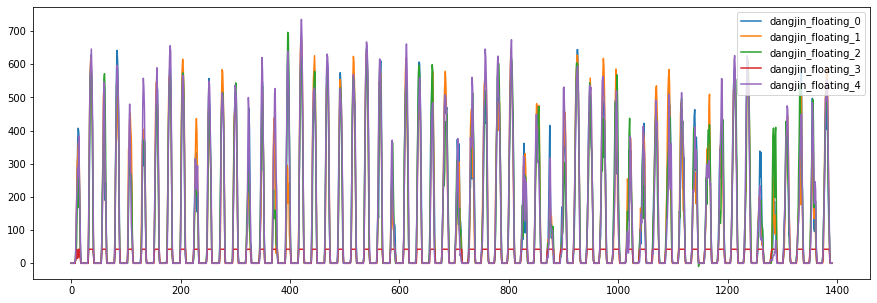

In [ ]:
plt.figure(figsize=(15, 5))
m = 'dangjin_floating'
# Fold별 모델 예측결과 시각화
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
preds = []
m = 'dangjin_floating'
# Fold별 모델 예측결과 시각화, 가장 예측이 잘 되지 않은 Fold를 시각적으로 확인한 후 제거하고 다시 시각화
for i in range(5):
  if i == 3: pass # 다른 Fold와 확연하게 다른 예측성능이 떨어지는  Predict plot을 그리고 있기 때문에 모델성능 향상을 위해 제거
  else:
    model = set_model()
    model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
    pred = model.predict(X_test)
    preds.append(pred)

# 예측이 잘 이루어지지 않은 Fold 를 제거하고 Mean
dangjin_floating_pred = np.mean(preds, axis=0)

In [ ]:
len(preds)

4

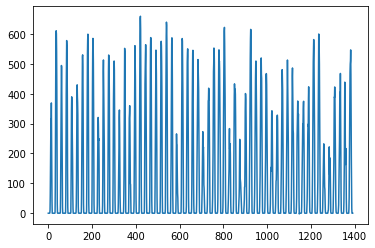

In [ ]:
plt.plot(dangjin_floating_pred)

## dangjin_warehouse

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_warehouse_df, 'dangjin_warehouse')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 에측

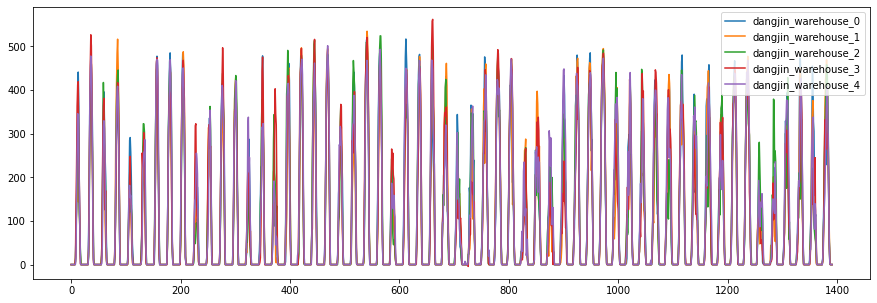

In [ ]:
plt.figure(figsize=(15, 5))
m = 'dangjin_warehouse'
# Fold별 모델 예측결과 시각화
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
preds = []
m = 'dangjin_warehouse'
# Fold별 모델 예측결과 시각화, 가장 예측이 잘 되지 않은 Fold를 시각적으로 확인한 후 제거하고 다시 시각화 ( 여기서는 제거하는 Fold 없음 )
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5') 
  pred = model.predict(X_test)
  preds.append(pred)

dangjin_warehouse_pred = np.mean(preds, axis=0) # 모든 Fold가 비슷한 성능을 보이고 있기 때문에 제거없이 Mean

In [ ]:
len(preds)

5

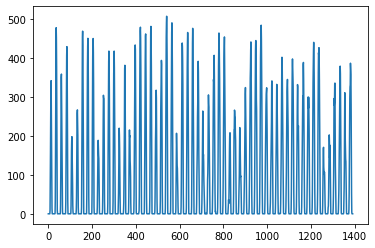

In [ ]:
plt.plot(dangjin_warehouse_pred)

## dangjin

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_df, 'dangjin')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 에측

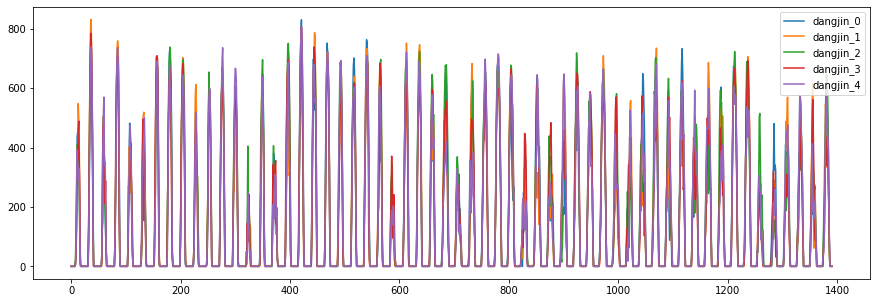

In [ ]:
plt.figure(figsize=(15, 5))
m = 'dangjin'
# Fold별 모델 예측결과 시각화
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
preds = []
m = 'dangjin'
# Fold별 모델 예측결과 시각화, 가장 예측이 잘 되지 않은 Fold를 시각적으로 확인한 후 제거하고 다시 시각화 ( 여기서는 제거하는 Fold 없음 )
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  preds.append(pred)

dangjin_pred = np.mean(preds, axis=0) # 모든 Fold가 비슷한 성능을 보이고 있기 때문에 제거없이 Mean

In [ ]:
len(preds)

5

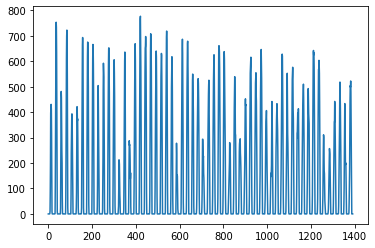

In [ ]:
plt.plot(dangjin_pred)

## ulsan

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(ulsan_df, 'ulsan')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 에측

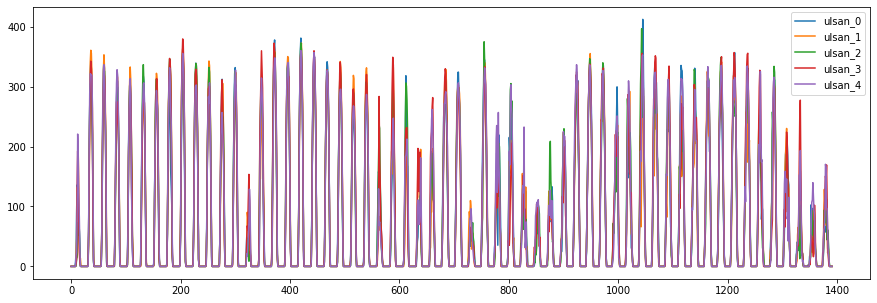

In [ ]:
plt.figure(figsize=(15, 5))
m = 'ulsan'
# Fold별 모델 예측결과 시각화
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
preds = []
m = 'ulsan'
# Fold별 모델 예측결과 시각화, 가장 예측이 잘 되지 않은 Fold를 시각적으로 확인한 후 제거하고 다시 시각화 ( 여기서는 제거하는 Fold 없음 )
for i in range(5):
  model = set_model()
  model.load_weights(model_paths + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  preds.append(pred)

ulsan_pred = np.mean(preds, axis=0) # 모든 Fold가 비슷한 성능을 보이고 있기 때문에 제거없이 Mean

In [ ]:
len(preds)

5

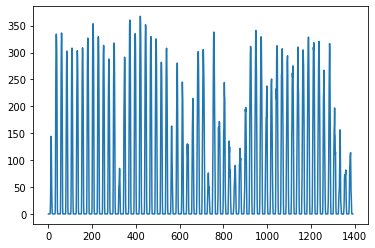

In [ ]:
plt.plot(ulsan_pred)

## 예측

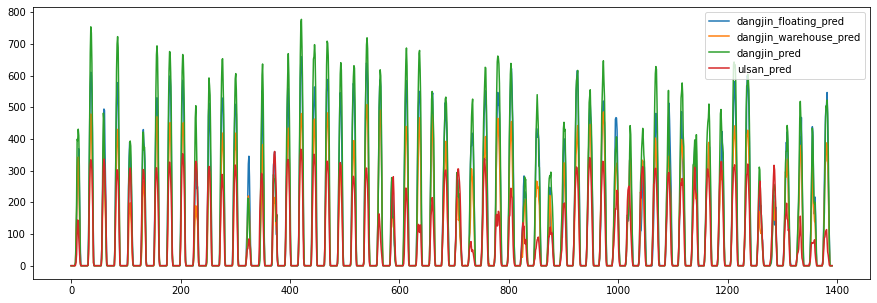

In [ ]:
# 각 모델별 예측 결과 Plot
plt.figure(figsize=(15, 5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission.iloc[ : , 1] = dangjin_floating_pred
submission.iloc[ : , 2] = dangjin_warehouse_pred
submission.iloc[ : , 3] = dangjin_pred
submission.iloc[ : , 4] = ulsan_pred

In [ ]:
submission.to_csv('CNN1D_ret.csv', index=False)
submission.iloc[ : , :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002885,-0.000154,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002589,-0.000232,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002539,-0.000134,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002739,-0.000060,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003024,-0.000095,-0.000116,0.000045
...,...,...,...,...,...
1387,2021-07-08 20:00:00,14.803840,4.024741,0.001304,0.000045
1388,2021-07-08 21:00:00,0.002514,-0.000337,-0.000116,0.000045
1389,2021-07-08 22:00:00,0.002394,-0.000258,-0.000116,0.000045
1390,2021-07-08 23:00:00,0.002308,-0.000205,-0.000116,0.000045


# 리더보드 복원 확인

In [ ]:
result_sub = pd.read_csv('CNN1D_0707_17_ret.csv')
predict_sub = pd.read_csv('CNN1D_ret.csv')

In [ ]:
result_sub.head(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002887,0.000034,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002585,-0.000061,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002537,0.000062,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002730,0.000148,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003015,0.000109,-0.000116,0.000045
5,2021-02-01 06:00:00,0.003677,0.000085,-0.000116,0.000045
6,2021-02-01 07:00:00,0.003894,-0.000076,-0.000116,0.000045
7,2021-02-01 08:00:00,0.929345,-0.000064,0.841855,0.000045
8,2021-02-01 09:00:00,10.371879,9.637656,11.320709,0.964414
9,2021-02-01 10:00:00,60.291733,85.034882,86.530907,10.746229


In [ ]:
predict_sub.head(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002885,-0.000154,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002589,-0.000232,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002539,-0.000134,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002739,-0.000060,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003024,-0.000095,-0.000116,0.000045
5,2021-02-01 06:00:00,0.003685,-0.000115,-0.000116,0.000045
6,2021-02-01 07:00:00,0.003899,-0.000237,-0.000116,0.000045
7,2021-02-01 08:00:00,1.037492,-0.000220,0.841455,0.000045
8,2021-02-01 09:00:00,10.460457,9.211689,11.185345,1.307830
9,2021-02-01 10:00:00,60.357834,79.212715,86.234116,11.676592


In [ ]:
result_sub.iloc[(24 * 28) : (24 * 28) + 24, :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
672,2021-06-09 01:00:00,0.002611,-0.000188,-0.000116,0.000045
673,2021-06-09 02:00:00,0.005637,-0.000143,-0.000116,0.000045
674,2021-06-09 03:00:00,0.002545,-0.000123,-0.000116,0.000045
675,2021-06-09 04:00:00,0.002336,-0.000202,-0.000116,0.000045
676,2021-06-09 05:00:00,0.002540,-0.000165,-0.000116,0.000045
677,2021-06-09 06:00:00,0.962114,0.029312,2.285660,0.005207
678,2021-06-09 07:00:00,35.294762,26.703842,21.495232,25.709436
679,2021-06-09 08:00:00,115.172760,93.903305,85.089684,74.052940
680,2021-06-09 09:00:00,197.810272,124.264793,220.152802,143.657501
681,2021-06-09 10:00:00,294.817047,169.877594,311.044281,213.187592


In [ ]:
predict_sub.iloc[(24 * 28) : (24 * 28) + 24, :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
672,2021-06-09 01:00:00,0.002613,-0.000187,-0.000116,0.000045
673,2021-06-09 02:00:00,0.006869,-0.000142,-0.000116,0.000045
674,2021-06-09 03:00:00,0.002543,-0.000119,-0.000116,0.000045
675,2021-06-09 04:00:00,0.002333,-0.000201,-0.000116,0.000045
676,2021-06-09 05:00:00,0.002541,-0.000165,-0.000116,0.000045
677,2021-06-09 06:00:00,0.946207,0.017531,2.175927,0.004350
678,2021-06-09 07:00:00,35.362232,26.653940,21.679266,25.682043
679,2021-06-09 08:00:00,115.501244,93.915176,85.063766,73.999161
680,2021-06-09 09:00:00,197.736496,124.434692,220.042313,143.813217
681,2021-06-09 10:00:00,295.383423,170.092392,310.622986,213.515869


In [ ]:
result_sub.tail(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
1368,2021-07-08 01:00:00,0.002512,-0.000100,-0.000116,0.000045
1369,2021-07-08 02:00:00,0.002540,-0.000206,-0.000116,0.000045
1370,2021-07-08 03:00:00,0.002464,-0.000156,-0.000116,0.000045
1371,2021-07-08 04:00:00,0.002251,-0.000391,-0.000116,0.000045
1372,2021-07-08 05:00:00,0.010027,-0.000245,-0.000116,0.000045
1373,2021-07-08 06:00:00,0.002251,-0.000270,-0.000116,0.000045
1374,2021-07-08 07:00:00,14.533589,11.060273,5.540959,7.759534
1375,2021-07-08 08:00:00,51.805302,52.393780,46.703117,25.694103
1376,2021-07-08 09:00:00,152.677933,119.057739,117.144958,59.310772
1377,2021-07-08 10:00:00,240.278366,217.574539,168.118713,88.191605


In [ ]:
predict_sub.tail(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
1368,2021-07-08 01:00:00,0.002512,-0.000100,-0.000116,0.000045
1369,2021-07-08 02:00:00,0.002540,-0.000206,-0.000116,0.000045
1370,2021-07-08 03:00:00,0.002464,-0.000156,-0.000116,0.000045
1371,2021-07-08 04:00:00,0.002251,-0.000391,-0.000116,0.000045
1372,2021-07-08 05:00:00,0.010028,-0.000245,-0.000116,0.000045
1373,2021-07-08 06:00:00,0.002251,-0.000270,-0.000116,0.000045
1374,2021-07-08 07:00:00,14.533606,11.060264,5.540955,7.759528
1375,2021-07-08 08:00:00,51.805313,52.393806,46.703114,25.694067
1376,2021-07-08 09:00:00,152.677979,119.057816,117.144997,59.310863
1377,2021-07-08 10:00:00,240.278397,217.574615,168.118729,88.191589
